In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
from datetime import datetime
import numpy as np
import tracemalloc

sample_walls = sp.testing.shoebox_room_stub(1, 1, 1)

In [3]:
def init_energy(rad, source_pos):
    source = geo.SoundSource(source_pos, [1, 0, 0], [0, 0, 1])
    E_matrix = []
    for patches in rad.patch_list:
        patches.init_energy_exchange(
            rad.max_order_k, rad.ir_length_s, source,
            sampling_rate=rad.sampling_rate)
        E_matrix.append(patches.E_matrix)
    return E_matrix

def calc_form_factor(rad):
    if len(rad.patch_list) > 1:
        for patches in rad.patch_list:
            patches.calculate_form_factor(rad.patch_list)


In [4]:
n_max = 5
repeat = 2
steps = 3 # create patches, init energy, form factor
steps_names = ['create patches', 'init energy', 'form factor']
fast_second = np.zeros((steps, n_max, repeat))
memory_fast = np.zeros((steps, n_max, repeat))
memory_slow = np.zeros((steps, n_max, repeat))
# memory_slow[:] = np.nan
slow = np.zeros((steps, n_max, repeat))
# slow[:] = np.nan
number_of_patches = np.zeros((n_max))

# run one time, to get complied.
radiosity = DRadiosityFast.from_polygon(sample_walls, 1)
(energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
radiosity.check_visibility()
radiosity.calculate_form_factors()

for i in range(n_max):
    max_size = 1/(2**i)
    start_loop = datetime.now()
    print(f'{datetime.now()} run({i+1}/{n_max}): {max_size}')
    # run fast two times
    for j in range(repeat):
        # create patches
        tracemalloc.start()
        start = datetime.now()
        radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)
        delta = (datetime.now() - start)
        memory_fast[0, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # init_energy
        tracemalloc.start()
        start = datetime.now()
        (energy, distance) = radiosity.init_energy([0.5, 0.5, 0.5])
        delta = (datetime.now() - start)
        memory_fast[1, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        tracemalloc.start()
        start = datetime.now()
        radiosity.check_visibility()
        radiosity.calculate_form_factors()
        delta = (datetime.now() - start)
        memory_fast[2, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

    number_of_patches[i] = radiosity.n_patches
    if i < 4:
        # Run old
        for j in range(repeat):
            # create patches
            tracemalloc.start()
            start = datetime.now()
            radiosity_old = Radiosity(sample_walls, max_size, 0, 1)
            delta = (datetime.now() - start)
            slow[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[0, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # init_energy
            tracemalloc.start()
            start = datetime.now()
            E_matrix = init_energy(radiosity_old, [0.5, 0.5, 0.5])
            delta = (datetime.now() - start)
            slow[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[1, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # form factor
            tracemalloc.start()
            start = datetime.now()
            calc_form_factor(radiosity_old)
            delta = (datetime.now() - start)
            slow[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[2, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()
    delta = (datetime.now() - start_loop)
    delta_seconds = (delta.seconds*1e6 + delta.microseconds)*1e-6
    print(f'{datetime.now()}   took {delta_seconds} seconds')


2024-06-02 12:43:17.655837 run(1/5): 1.0


/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


2024-06-02 12:43:19.626789   took 1.970956 seconds
2024-06-02 12:43:19.626845 run(2/5): 0.5
2024-06-02 12:43:19.935703   took 0.308857 seconds
2024-06-02 12:43:19.935727 run(3/5): 0.25
2024-06-02 12:43:24.532504   took 4.596775 seconds
2024-06-02 12:43:24.532576 run(4/5): 0.125
2024-06-02 12:44:36.488048   took 71.955471 seconds
2024-06-02 12:44:36.488123 run(5/5): 0.0625
2024-06-02 12:45:05.012049   took 28.523922 seconds


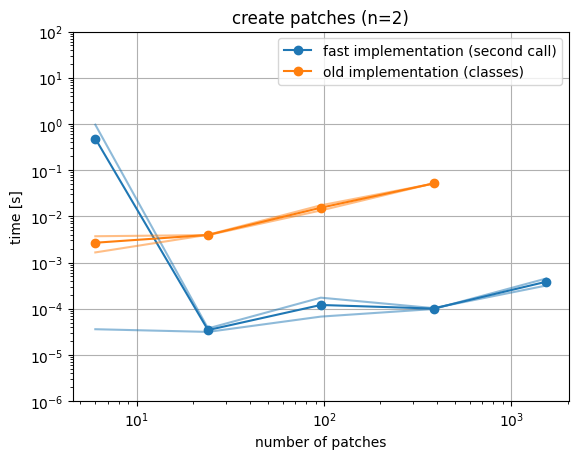

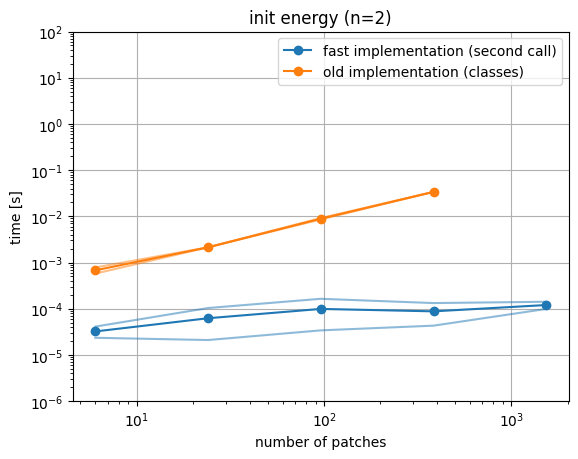

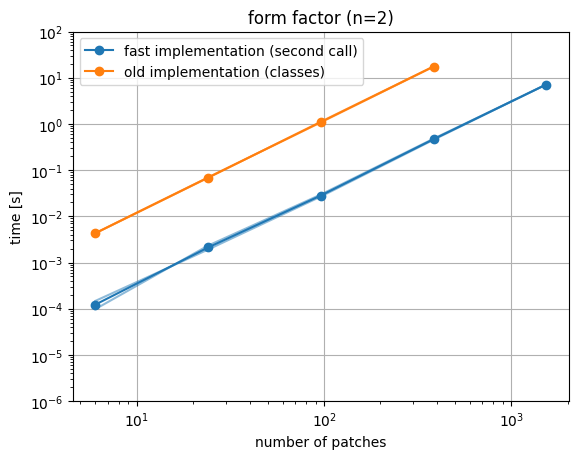

In [5]:
import matplotlib.pyplot as plt
slow[slow == 0] = np.nan
# plot time to compute
for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(fast_second[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, fast_second[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('time [s]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

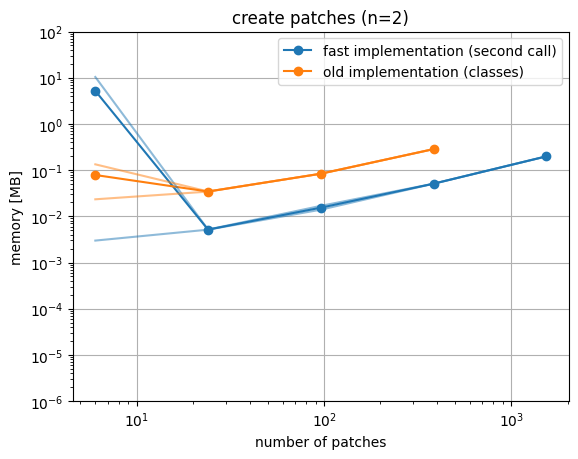

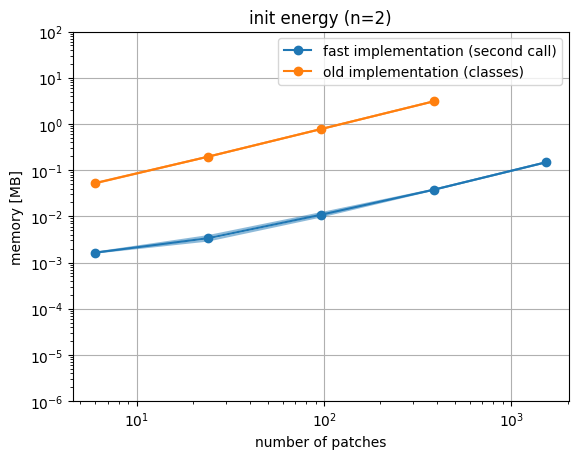

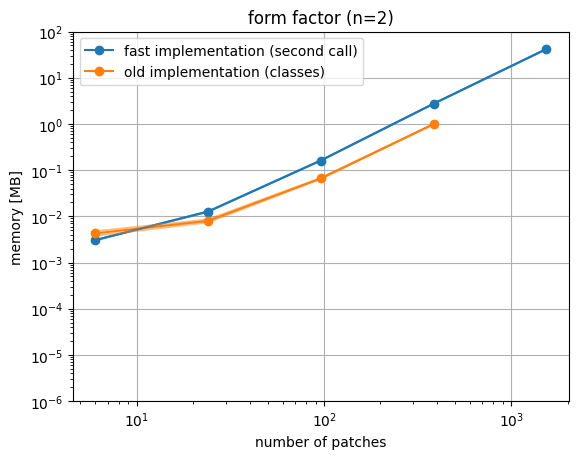

In [6]:
# plot memory consumption
memory_slow[memory_slow == 0] = np.nan
for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(memory_fast[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(memory_slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, memory_fast[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, memory_slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('memory [MB]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

In [9]:
r = np.sum(radiosity.form_factors==0) / radiosity.form_factors.size
print(f'ratio of zeros of form factors: {r*100:.2f}%')

ratio of zeros of form factors: 58.33%
